In [1]:
! pip install -q kaggle

##### Это было для google.colab

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lyubovrogozina","key":"7eea4d9761ef63ccdabc2c31eac893ce"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#### Датасет с отзывами о ресторанах макдональдс - но можно наверное экстраполировать на другой общепит

In [3]:
!kaggle datasets download nelgiriyewithana/mcdonalds-store-reviews

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews
License(s): other
  0%|                                               | 0.00/1.78M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.78M/1.78M [00:00<00:00, 658MB/s]


___А это я ушла локально на машину из колаба___

In [6]:
# ! unzip /content/mcdonalds-store-reviews.zip -d /content
! unzip ./mcdonalds-store-reviews.zip -d ./content

Archive:  ./mcdonalds-store-reviews.zip
  inflating: ./content/McDonald_s_Reviews.csv  


In [7]:
pip install transformers datasets evaluate accelerate

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 56.5 kB/s eta 0:00:0000:0500:10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 53.1 kB/s eta 0:00:0000:0200:23
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.2 kB/s eta 0:00:00a 0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.7 kB/s eta 0:00:00a 0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.8 kB/s eta 0:00:0000:0300:09
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 45.0 kB/s eta 0:00:0000:0200:14
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 46.5 kB/s eta 0:00:0000:0100:25


In [1]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pandas as pd

/home/new_cybrid/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Сентемент анализ отзывов - но с попыткой классификации от 1 до 5

In [3]:
id_key = {0: '1 star', 1: '2 stars', 2: '3 stars', 3: '4 stars', 4: '5 stars'}
label_key = {'1 star': 0, '2 stars': 1, '3 stars': 2, '4 stars': 3, '5 stars': 4}


__Разбиение одного csv на тестовую, тренировочную валидационную выборки, удаление лишних параметров, преобразование в типы для dataset и переменование для модели__

In [5]:
from datasets import load_dataset
from datasets import Features, ClassLabel, Value, DatasetDict
#features = Features({'rating': ClassLabel(num_classes=5, names=list(label_key.keys())), 'review': Value('string')})
loaded_dataset = load_dataset('csv', data_files='./content/McDonald_s_Reviews.csv', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], encoding='latin-1')
dataset = DatasetDict()
dataset['train'] = loaded_dataset[0].class_encode_column('rating').remove_columns(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'review_time', 'rating_count']).rename_columns({'review': 'text', 'rating': 'label'})
dataset['validation'] = loaded_dataset[1].class_encode_column('rating').remove_columns(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'review_time', 'rating_count']).rename_columns({'review': 'text', 'rating': 'label'})
dataset['test'] = loaded_dataset[2].class_encode_column('rating').remove_columns(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'review_time', 'rating_count']).rename_columns({'review': 'text', 'rating': 'label'})
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'], id=None)}

In [6]:
def get_tokenizer(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)

tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
tokenized_dataset = dataset.map(get_tokenizer, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_dataset['train']

Map: 100%|██████████| 6679/6679 [00:00<00:00, 53523.06 examples/s]


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 20038
})

In [7]:
accuracy = evaluate.load('accuracy')

__5 лейблов для модели__

In [8]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=5, id2label=id_key, label2id=label_key)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def get_acc(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

__10 эпох, сначала было 50, но очень все долго показалось. Все равно на 6 пошло переобучение__

In [10]:
training_args = TrainingArguments(output_dir='results', learning_rate=1e-4, per_device_train_batch_size=32, per_device_eval_batch_size=32, num_train_epochs=10, weight_decay=0.01, eval_strategy='epoch', save_strategy='epoch', save_total_limit=4, load_best_model_at_end=True)

/home/new_cybrid/.local/lib/python3.13/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [18]:
trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_dataset["train"], eval_dataset=tokenized_dataset["validation"], tokenizer=tokenizer, data_collator=data_collator, compute_metrics=get_acc, callbacks=[EarlyStoppingCallback(early_stopping_patience=4)])

trainer.train()

/tmp/ipykernel_8695/441602812.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_dataset["train"], eval_dataset=tokenized_dataset["validation"], tokenizer=tokenizer, data_collator=data_collator, compute_metrics=get_acc, callbacks=[EarlyStoppingCallback(early_stopping_patience=4)])


Epoch,Training Loss,Validation Loss,Accuracy
1,0.888200,0.821113,0.680940
2,0.770800,0.818753,0.673005
3,0.660900,0.847881,0.683785
4,0.459700,1.074059,0.649199
5,0.352200,1.240006,0.668513
6,0.292300,1.415864,0.657733


/home/new_cybrid/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/new_cybrid/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/new_cybrid/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/new_cybrid/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/new_cybrid/.local/lib/python3.13/site-packages/torch/u

TrainOutput(global_step=3762, training_loss=0.5496855395579199, metrics={'train_runtime': 20723.7219, 'train_samples_per_second': 9.669, 'train_steps_per_second': 0.303, 'total_flos': 6952789875670920.0, 'train_loss': 0.5496855395579199, 'epoch': 6.0})

In [11]:
targets = dataset['test']['label']

In [12]:
dataset['test']['text'][0:10]

['Nice clean location. Customer service was super friendly and professional. Nice seating available. Outside seating also available. This location has 24 hr drive through. Overall great experience. Keep up the good work!',
 'TERRIBLE. Got our orders wrong and when I got home it was missing my entire meal...\nNEVER WILL I EVER RETURN HERE.\n\nManager Rosalina or Rosaline is terrible as well she is clueless and she has no idea how to repay or provide refund for this mistake. She called back saying she canï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½t do anything Iï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½m too busy I canï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï',
 'This place has changed for the worse in the past few months. Previously well-staffed with courteous people. Now they donï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½t even look at you when you place your order. N

In [14]:
pipe = pipeline('text-classification', model='results/checkpoint-3762')


Device set to use cpu


#### Получение предсказаний для модели - если текст слишком длинный, он обезается

In [11]:

predictions = []

def process_long_text(text, max_len=512):
    if len(text) <= max_len:
        return pipe(text)[0]
    else:
        mid = len(text) // 2
        first_half = text[:mid]
        second_half = text[mid:]
        result1 = process_long_text(first_half, max_len)
        result2 = process_long_text(second_half, max_len)
        return result1 if result1['score'] > result2['score'] else result2

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device set to use {device}")

for text in dataset['test']['text']:
    try:
        result = process_long_text(text)
        predictions.append(label_key[result['label']])
    except Exception as e:
        print(f"Error processing text: {e}")
        predictions.append('1 star')

Device set to use cpu


Device set to use cpu


" for out in pipe(KeyDataset(tokenized_dataset['test'], 'text')):\n    predictions.append(label_key[out['label']]) "

In [14]:
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      2127
           1       0.38      0.46      0.42       646
           2       0.54      0.51      0.53       826
           3       0.51      0.51      0.51      1043
           4       0.79      0.77      0.78      2037

    accuracy                           0.68      6679
   macro avg       0.61      0.61      0.61      6679
weighted avg       0.69      0.68      0.69      6679



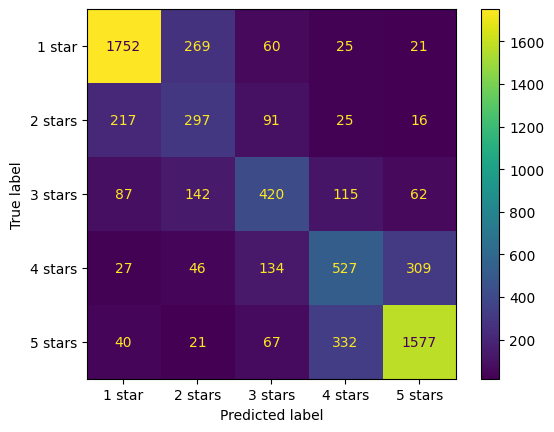

In [15]:
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm, display_labels=np.array(list(label_key.keys()))).plot()

[Пример отзыва на google maps на ресторан](https://maps.app.goo.gl/SwxAJsxxkcBugqk38) (5 звезд)

In [15]:
text = """I had to see what the hype was about… and I have to admit, it kind of exceeded my expectations. The ambiance, service, and food were really good! I came for the burger and the lasagna, but my favorite dish ended up being the polenta bread. I might be biased because I absolutely love bread… but something about the dough and the ingredients just hit. It was simple and not too overwhelming, a must get for carb lovers like myself. It was so good, we ended up ordering another after our entrees.

The burger was juicy and flavorful. Was it my favorite burger in NYC? No. But was it still really delicious and tasty? Yes! The lasagna was thin and I found that I actually enjoy this version more than the traditional lasagnas. It’s not as heavy. Overall, great experience!"""

pipe(text)

[{'label': '4 stars', 'score': 0.7862470149993896}]

[Пример отзыва на google maps на ресторан](https://maps.app.goo.gl/k4vE66PVDtR76YPB9) (2 звезды)

In [16]:
text_2 = """Some time the bartender who cover there very unwelcome the guest.
Reasonable price
Not busy in the weekend"""

pipe(text_2)

[{'label': '3 stars', 'score': 0.5171878933906555}]

#### Вывод: при сентемент анализе текстов и многоклассовой классификации модель ошибается на соседних классах, особенно если они не являются самыми частыми и выраженными, но в целом общая тенденция улавливается. Наверное стоит делить все-таки на позитивные и негативные, но в реальных задачах может поребоваться предсказание и по большему числу лейблов, чем два, поэтому как-то так